Metallic Dataset

In [2]:
cd /content/drive/My Drive/AI lab

/content/drive/My Drive/AI lab


In [ ]:
pip install nsepy

In [ ]:
pip install tensorflow

In [4]:
from nsepy import get_history as gh
import datetime as dt
from matplotlib import pyplot as plt
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [5]:
#Importing the dataset
df=pd.read_csv("Stock_ZMYD1.csv")
df.head()

,Unnamed: 0,<TICKER>,<DTYYYYMMDD>,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,<OPENINT>,<PER>,<OPEN>,<LAST>
0,0,Zamyad,20010408,16387.0,16690.0,16379.0,16690.0,105522480,6413,62,D,0.0,16690.0
1,1,Zamyad,20010410,16495.0,16495.0,16495.0,16495.0,3364980,204,1,D,16690.0,16495.0
2,2,Zamyad,20010411,16200.0,16200.0,16000.0,16000.0,66762000,4170,18,D,16495.0,16000.0
3,3,Zamyad,20010414,16000.0,16000.0,15700.0,16000.0,154041834,9654,85,D,16000.0,16000.0
4,4,Zamyad,20010415,16000.0,16200.0,16000.0,16200.0,50549340,3143,26,D,16000.0,16200.0


In [6]:
df['datetime'] = pd.to_datetime(df['<DTYYYYMMDD>'], format='%Y%m%d')
df.index = df['datetime']
df.dropna()
df_new = df[["<FIRST>","<HIGH>","<LOW>","<CLOSE>","<VALUE>","<VOL>"]]
df_new.head()

,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>
datetime,,,,,,
2001-04-08,16387.0,16690.0,16379.0,16690.0,105522480,6413
2001-04-10,16495.0,16495.0,16495.0,16495.0,3364980,204
2001-04-11,16200.0,16200.0,16000.0,16000.0,66762000,4170
2001-04-14,16000.0,16000.0,15700.0,16000.0,154041834,9654
2001-04-15,16000.0,16200.0,16000.0,16200.0,50549340,3143


###Calculating the technical indicators

In [7]:
#1. Simple n day moving average
def moving_average(df, n):
    """Calculate the moving average for the given data.
    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    MA = pd.Series(df['<CLOSE>'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    df = df.join(MA)
    return df
df_new = moving_average(df_new,10)
df_new.tail()

,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,MA_10
datetime,,,,,,,
2020-05-20,11149.0,11149.0,11149.0,11149.0,97550739770,8749730,9420.5
2020-05-23,11680.0,11706.0,11150.0,11643.0,1613620738967,138593153,9797.0
2020-05-30,11061.0,11061.0,11061.0,11061.0,148747841316,13447956,10090.2
2020-05-31,10508.0,10508.0,10508.0,10727.0,27225387360,2590920,10314.2
2020-06-01,10191.0,10191.0,10191.0,10242.0,39620600373,3887803,10454.2


In [8]:
#2. Weighted Moving Average (WMA)
def weighted_moving_average(df, n):
    """
    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    WMA = pd.Series(df['<CLOSE>'].ewm(span=n, min_periods=n).mean(), name='WMA_' + str(n))
    df = df.join(WMA)
    return df
df_new = weighted_moving_average(df_new,10)
df_new.tail()

,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,MA_10,WMA_10
datetime,,,,,,,,
2020-05-20,11149.0,11149.0,11149.0,11149.0,97550739770,8749730,9420.5,9512.588423
2020-05-23,11680.0,11706.0,11150.0,11643.0,1613620738967,138593153,9797.0,9899.935982
2020-05-30,11061.0,11061.0,11061.0,11061.0,148747841316,13447956,10090.2,10111.038531
2020-05-31,10508.0,10508.0,10508.0,10727.0,27225387360,2590920,10314.2,10223.031525
2020-06-01,10191.0,10191.0,10191.0,10242.0,39620600373,3887803,10454.2,10226.480339


In [9]:
#3. Momentum
def momentum(df, n):
    """
    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    M = pd.Series(df['<CLOSE>'].diff(n), name='MOM_' + str(n))
    df = df.join(M)
    return df
df_new = momentum(df_new,10)
df_new.tail()

,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,MA_10,WMA_10,MOM_10
datetime,,,,,,,,,
2020-05-20,11149.0,11149.0,11149.0,11149.0,97550739770,8749730,9420.5,9512.588423,3534.0
2020-05-23,11680.0,11706.0,11150.0,11643.0,1613620738967,138593153,9797.0,9899.935982,3765.0
2020-05-30,11061.0,11061.0,11061.0,11061.0,148747841316,13447956,10090.2,10111.038531,2932.0
2020-05-31,10508.0,10508.0,10508.0,10727.0,27225387360,2590920,10314.2,10223.031525,2240.0
2020-06-01,10191.0,10191.0,10191.0,10242.0,39620600373,3887803,10454.2,10226.480339,1400.0


In [10]:
#4. Stochastic K%
def stochastic_oscillator_k(df):
    """Calculate stochastic oscillator %K for given data.
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['<CLOSE>'] - df['<LOW>']) / (df['<HIGH>'] - df['<LOW>']), name='SO_k')
    df = df.join(SOk)
    return df
df_new = stochastic_oscillator_k(df_new)
df_new.tail()

,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,MA_10,WMA_10,MOM_10,SO_k
datetime,,,,,,,,,,
2020-05-20,11149.0,11149.0,11149.0,11149.0,97550739770,8749730,9420.5,9512.588423,3534.0,NaN
2020-05-23,11680.0,11706.0,11150.0,11643.0,1613620738967,138593153,9797.0,9899.935982,3765.0,0.886691
2020-05-30,11061.0,11061.0,11061.0,11061.0,148747841316,13447956,10090.2,10111.038531,2932.0,NaN
2020-05-31,10508.0,10508.0,10508.0,10727.0,27225387360,2590920,10314.2,10223.031525,2240.0,inf
2020-06-01,10191.0,10191.0,10191.0,10242.0,39620600373,3887803,10454.2,10226.480339,1400.0,inf


In [11]:
#5. Stochastic D%
def stochastic_oscillator_d(df, n):
    """Calculate stochastic oscillator %D for given data.
    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    SOk = pd.Series((df['<CLOSE>'] - df['<LOW>']) / (df['<HIGH>'] - df['<LOW>']), name='SO%k')
    SOd = pd.Series(SOk.ewm(span=n, min_periods=n).mean(), name='SO_' + str(n))
    df = df.join(SOd)
    return df
df_new = stochastic_oscillator_d(df_new,10)
df_new.tail()

,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,MA_10,WMA_10,MOM_10,SO_k,SO_10
datetime,,,,,,,,,,,
2020-05-20,11149.0,11149.0,11149.0,11149.0,97550739770,8749730,9420.5,9512.588423,3534.0,NaN,0.781149
2020-05-23,11680.0,11706.0,11150.0,11643.0,1613620738967,138593153,9797.0,9899.935982,3765.0,0.886691,0.827007
2020-05-30,11061.0,11061.0,11061.0,11061.0,148747841316,13447956,10090.2,10111.038531,2932.0,NaN,0.827007
2020-05-31,10508.0,10508.0,10508.0,10727.0,27225387360,2590920,10314.2,10223.031525,2240.0,inf,0.827007
2020-06-01,10191.0,10191.0,10191.0,10242.0,39620600373,3887803,10454.2,10226.480339,1400.0,inf,0.827007


In [ ]:
#6. Relative Strength Index
#Error
"""
def relative_strength_index(df, n):
    Calculate Relative Strength Index(RSI) for given data.
    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    i = df.index[0]
    UpI = [0]
    DoI = [0]
    while i + 1 <= df.index[-1]:
        UpMove = float(df.loc[i + 1, 'high']) - float(df.loc[i, 'high'])
        DoMove = float(df.loc[i, 'low']) - float(df.loc[i + 1, 'low'])
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)

    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())

    # rsi = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    rsi = pd.DataFrame(PosDI / (PosDI + NegDI), columns=['RSI_' + str(n)])
    rsi = rsi.set_index(df.index)
    df = df.join(rsi)
    return df
"""

In [12]:

#7. Signal
def macd(df, n_fast, n_slow):
    """Calculate MACD, MACD Signal and MACD difference
    :param df: pandas.DataFrame
    :param n_fast:
    :param n_slow:
    :return: pandas.DataFrame
    """
    EMAfast = pd.Series(df['<CLOSE>'].ewm(span=n_fast, min_periods=n_slow).mean())
    EMAslow = pd.Series(df['<CLOSE>'].ewm(span=n_slow, min_periods=n_slow).mean())
    MACD = pd.Series(EMAfast - EMAslow, name='MACD_' + str(n_fast) + '_' + str(n_slow))
    MACDsign = pd.Series(MACD.ewm(span=9, min_periods=9).mean(), name='MACDsign_' + str(n_fast) + '_' + str(n_slow))
    MACDdiff = pd.Series(MACD - MACDsign, name='MACDdiff_' + str(n_fast) + '_' + str(n_slow))
    df = df.join(MACD)
    df = df.join(MACDsign)
    df = df.join(MACDdiff)
    return df
df_new = macd(df_new,12,26)
df_new.head()

,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,MA_10,WMA_10,MOM_10,SO_k,SO_10,MACD_12_26,MACDsign_12_26,MACDdiff_12_26
datetime,,,,,,,,,,,,,,
2001-04-08,16387.0,16690.0,16379.0,16690.0,105522480,6413,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2001-04-10,16495.0,16495.0,16495.0,16495.0,3364980,204,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-04-11,16200.0,16200.0,16000.0,16000.0,66762000,4170,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
2001-04-14,16000.0,16000.0,15700.0,16000.0,154041834,9654,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
2001-04-15,16000.0,16200.0,16000.0,16200.0,50549340,3143,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN


In [16]:
#8. Larry Williams R%
#lEFT

In [13]:
#9. Accumulation / Distribution
def accumulation_distribution(df, n):
    """Calculate Accumulation/Distribution for given data.
    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    ad = (2 * df['<CLOSE>'] - df['<HIGH>'] - df['<LOW>']) / (df['<HIGH>'] - df['<LOW>']) * df['<VOL>']
    M = ad.diff(n - 1)
    N = ad.shift(n - 1)
    ROC = M / N
    AD = pd.Series(ROC, name='Acc/Dist_ROC_' + str(n))
    df = df.join(AD)
    return df
df_new = accumulation_distribution(df_new,10)
df_new.tail()

/usr/local/lib/python3.6/dist-packages/pandas/core/algorithms.py:1977: RuntimeWarning: invalid value encountered in subtract
  out_arr[res_indexer] = arr[res_indexer] - arr[lag_indexer]


,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,MA_10,WMA_10,MOM_10,SO_k,SO_10,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,Acc/Dist_ROC_10
datetime,,,,,,,,,,,,,,,
2020-05-20,11149.0,11149.0,11149.0,11149.0,97550739770,8749730,9420.5,9512.588423,3534.0,NaN,0.781149,1541.307481,1292.388846,248.918635,NaN
2020-05-23,11680.0,11706.0,11150.0,11643.0,1613620738967,138593153,9797.0,9899.935982,3765.0,0.886691,0.827007,1620.243747,1357.959826,262.283921,NaN
2020-05-30,11061.0,11061.0,11061.0,11061.0,148747841316,13447956,10090.2,10111.038531,2932.0,NaN,0.827007,1617.196733,1409.807208,207.389526,NaN
2020-05-31,10508.0,10508.0,10508.0,10727.0,27225387360,2590920,10314.2,10223.031525,2240.0,inf,0.827007,1569.736005,1441.792967,127.943038,inf
2020-06-01,10191.0,10191.0,10191.0,10242.0,39620600373,3887803,10454.2,10226.480339,1400.0,inf,0.827007,1475.973485,1448.629071,27.344415,NaN


In [14]:
#10. Commodity Channel Index
def commodity_channel_index(df, n):
    """Calculate Commodity Channel Index for given data.
    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    PP = (df['<HIGH>'] + df['<LOW>'] + df['<CLOSE>']) / 3
    CCI = pd.Series((PP - PP.rolling(n, min_periods=n).mean()) / PP.rolling(n, min_periods=n).std(),
                    name='CCI_' + str(n))
    df = df.join(CCI)
    return df
df_new = commodity_channel_index(df_new,10)
df_new.tail()

,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,MA_10,WMA_10,MOM_10,SO_k,SO_10,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,Acc/Dist_ROC_10,CCI_10
datetime,,,,,,,,,,,,,,,,
2020-05-20,11149.0,11149.0,11149.0,11149.0,97550739770,8749730,9420.5,9512.588423,3534.0,NaN,0.781149,1541.307481,1292.388846,248.918635,NaN,1.591967
2020-05-23,11680.0,11706.0,11150.0,11643.0,1613620738967,138593153,9797.0,9899.935982,3765.0,0.886691,0.827007,1620.243747,1357.959826,262.283921,NaN,1.521004
2020-05-30,11061.0,11061.0,11061.0,11061.0,148747841316,13447956,10090.2,10111.038531,2932.0,NaN,0.827007,1617.196733,1409.807208,207.389526,NaN,0.950491
2020-05-31,10508.0,10508.0,10508.0,10727.0,27225387360,2590920,10314.2,10223.031525,2240.0,inf,0.827007,1569.736005,1441.792967,127.943038,inf,0.350360
2020-06-01,10191.0,10191.0,10191.0,10242.0,39620600373,3887803,10454.2,10226.480339,1400.0,inf,0.827007,1475.973485,1448.629071,27.344415,NaN,-0.288717


In [15]:

df_new.mean()

<FIRST>            3.989101e+03
<HIGH>             4.037091e+03
<LOW>              3.944152e+03
<CLOSE>            4.000354e+03
<VALUE>            2.164058e+10
<VOL>              1.349677e+07
MA_10              3.977932e+03
WMA_10             3.978448e+03
MOM_10            -1.667698e+01
SO_k                        NaN
SO_10              5.221624e-01
MACD_12_26        -1.573275e+01
MACDsign_12_26    -1.712997e+01
MACDdiff_12_26     1.426747e+00
Acc/Dist_ROC_10             NaN
CCI_10            -5.582350e-02
dtype: float64

In [16]:
df_new.min()

<FIRST>            5.200000e+02
<HIGH>             5.300000e+02
<LOW>              5.180000e+02
<CLOSE>            5.250000e+02
<VALUE>            6.986000e+04
<VOL>              2.000000e+01
MA_10              5.415000e+02
WMA_10             5.424431e+02
MOM_10            -1.076600e+04
SO_k                       -inf
SO_10             -8.121225e+00
MACD_12_26        -2.694353e+03
MACDsign_12_26    -2.322452e+03
MACDdiff_12_26    -1.043022e+03
Acc/Dist_ROC_10            -inf
CCI_10            -2.846050e+00
dtype: float64

In [17]:
df_new.max()

<FIRST>            2.661500e+04
<HIGH>             2.661500e+04
<LOW>              2.661500e+04
<CLOSE>            2.661500e+04
<VALUE>            2.645561e+12
<VOL>              3.330094e+08
MA_10              2.321330e+04
WMA_10             2.260713e+04
MOM_10             1.511900e+04
SO_k                        inf
SO_10              1.027080e+00
MACD_12_26         4.497310e+03
MACDsign_12_26     3.896289e+03
MACDdiff_12_26     1.509492e+03
Acc/Dist_ROC_10             inf
CCI_10             2.840698e+00
dtype: float64

In [18]:
df_new.std()

<FIRST>            4.811431e+03
<HIGH>             4.866774e+03
<LOW>              4.765253e+03
<CLOSE>            4.836308e+03
<VALUE>            8.250127e+10
<VOL>              2.685984e+07
MA_10              4.794900e+03
WMA_10             4.783739e+03
MOM_10             1.171496e+03
SO_k                        NaN
SO_10              3.211372e-01
MACD_12_26         3.903220e+02
MACDsign_12_26     3.603874e+02
MACDdiff_12_26     1.280792e+02
Acc/Dist_ROC_10             NaN
CCI_10             1.260382e+00
dtype: float64

In [19]:
df_new=df_new.drop(['SO_k', 'Acc/Dist_ROC_10'], axis=1)
df_new.tail()

,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,MA_10,WMA_10,MOM_10,SO_10,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,CCI_10
datetime,,,,,,,,,,,,,,
2020-05-20,11149.0,11149.0,11149.0,11149.0,97550739770,8749730,9420.5,9512.588423,3534.0,0.781149,1541.307481,1292.388846,248.918635,1.591967
2020-05-23,11680.0,11706.0,11150.0,11643.0,1613620738967,138593153,9797.0,9899.935982,3765.0,0.827007,1620.243747,1357.959826,262.283921,1.521004
2020-05-30,11061.0,11061.0,11061.0,11061.0,148747841316,13447956,10090.2,10111.038531,2932.0,0.827007,1617.196733,1409.807208,207.389526,0.950491
2020-05-31,10508.0,10508.0,10508.0,10727.0,27225387360,2590920,10314.2,10223.031525,2240.0,0.827007,1569.736005,1441.792967,127.943038,0.350360
2020-06-01,10191.0,10191.0,10191.0,10242.0,39620600373,3887803,10454.2,10226.480339,1400.0,0.827007,1475.973485,1448.629071,27.344415,-0.288717


In [20]:
df_new=df_new.dropna()

In [21]:
df_new.tail()

,<FIRST>,<HIGH>,<LOW>,<CLOSE>,<VALUE>,<VOL>,MA_10,WMA_10,MOM_10,SO_10,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,CCI_10
datetime,,,,,,,,,,,,,,
2020-05-20,11149.0,11149.0,11149.0,11149.0,97550739770,8749730,9420.5,9512.588423,3534.0,0.781149,1541.307481,1292.388846,248.918635,1.591967
2020-05-23,11680.0,11706.0,11150.0,11643.0,1613620738967,138593153,9797.0,9899.935982,3765.0,0.827007,1620.243747,1357.959826,262.283921,1.521004
2020-05-30,11061.0,11061.0,11061.0,11061.0,148747841316,13447956,10090.2,10111.038531,2932.0,0.827007,1617.196733,1409.807208,207.389526,0.950491
2020-05-31,10508.0,10508.0,10508.0,10727.0,27225387360,2590920,10314.2,10223.031525,2240.0,0.827007,1569.736005,1441.792967,127.943038,0.350360
2020-06-01,10191.0,10191.0,10191.0,10242.0,39620600373,3887803,10454.2,10226.480339,1400.0,0.827007,1475.973485,1448.629071,27.344415,-0.288717


In [22]:
data_array = np.asarray(df_new)
data_array

array([[ 1.78010000e+04,  1.79110000e+04,  1.75810000e+04, ...,
         1.20534838e+02,  2.17923355e+02,  1.42566120e+00],
       [ 1.81030000e+04,  1.81170000e+04,  1.77940000e+04, ...,
         1.81933328e+02,  2.12630898e+02,  1.26252806e+00],
       [ 1.61020000e+04,  1.61020000e+04,  1.57000000e+04, ...,
         2.07546667e+02,  9.14525111e+01, -1.09138483e+00],
       ...,
       [ 1.10610000e+04,  1.10610000e+04,  1.10610000e+04, ...,
         1.40980721e+03,  2.07389526e+02,  9.50490629e-01],
       [ 1.05080000e+04,  1.05080000e+04,  1.05080000e+04, ...,
         1.44179297e+03,  1.27943038e+02,  3.50360337e-01],
       [ 1.01910000e+04,  1.01910000e+04,  1.01910000e+04, ...,
         1.44862907e+03,  2.73444146e+01, -2.88716897e-01]])

In [23]:
data_array.shape

(3856, 14)

In [24]:
feature=data_array[:, 7:14]
feature.shape

(3856, 7)

In [25]:
label=data_array[:, 4]
label.shape

(3856,)

In [34]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test=train_test_split(feature, label, test_size=0.30, random_state=42)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(2699, 7) (1157, 7) (2699,) (1157,)


In [37]:
x_train=x_train.reshape(1,2699,7)
x_test=x_test.reshape(1,1157,7)
y_train = y_train.reshape(1, 2699, 1)
y_test = y_test.reshape(1, 1157, 1)

In [46]:
print(y_train)

[[[1.55000000e+07 1.68368896e+09 4.60525000e+08 ... 7.60907475e+08
   2.20875093e+10 7.14641106e+09]]]


###Define the LSTM Recurrent Neural Network

In [40]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1], 7)))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

###Compile and train the model defined in the above step. Iteratively, you can increase or decrease the epochs and batch size to get more accuracy.

In [41]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(x_train, y_train, epochs = 15, batch_size = 32)

Epoch 1/15
1/1 [==============================] - 0s 2ms/step - loss: 5176618681584649764864.0000
Epoch 2/15
1/1 [==============================] - 0s 1ms/step - loss: 5176618681584649764864.0000
Epoch 3/15
1/1 [==============================] - 0s 2ms/step - loss: 5176618681584649764864.0000
Epoch 4/15
1/1 [==============================] - 0s 3ms/step - loss: 5176618681584649764864.0000
Epoch 5/15
1/1 [==============================] - 0s 2ms/step - loss: 5176618681584649764864.0000
Epoch 6/15
1/1 [==============================] - 0s 1ms/step - loss: 5176618681584649764864.0000
Epoch 7/15
1/1 [==============================] - 0s 2ms/step - loss: 5176618681584649764864.0000
Epoch 8/15
1/1 [==============================] - 0s 2ms/step - loss: 5176618681584649764864.0000
Epoch 9/15
1/1 [==============================] - 0s 1ms/step - loss: 5176618681584649764864.0000
Epoch 10/15
1/1 [==============================] - 0s 1ms/step - loss: 5176618681584649764864.0000
Epoch 11/15
1/1 [==

###Test the LSTM model on the new dataset.

In [62]:
x_test=x_test.reshape(1, 1157,7)

In [65]:
sc = MinMaxScaler(feature_range = (0, 1))
predicted_stock_price = regressor.predict(x_test)
# predicted_stock_price = sc.inverse_transform(predicted_stock_price)
# predicted_stock_price

In [66]:
real_stock_price = y_test
real_stock_price=real_stock_price.reshape(1157,1)

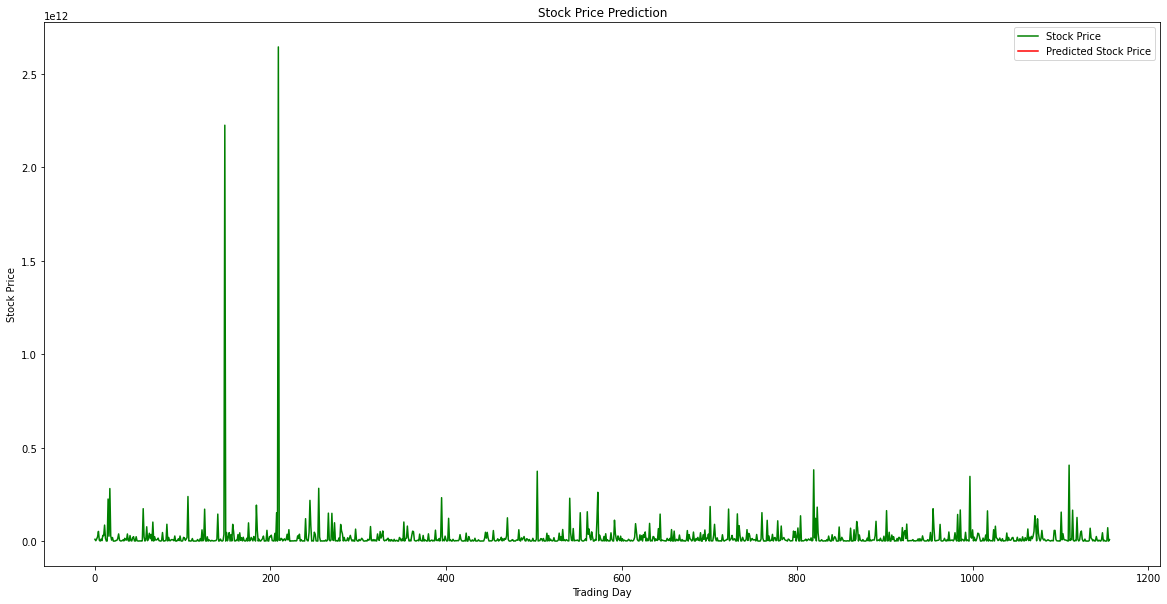

In [67]:
plt.figure(figsize=(20,10))
plt.plot(real_stock_price, color = 'green', label = 'Stock Price')
plt.plot(predicted_stock_price, color = 'red', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Trading Day')
plt.ylabel('Stock Price')
plt.legend()
plt.show()